## Import Libraries

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")


## Load JSON Data

In [15]:
df = pd.read_json("user-wallet-transactions.json")  # Update path if needed
df.head()


,_id,userWallet,network,protocol,txHash,logId,timestamp,blockNumber,action,actionData,__v,createdAt,updatedAt
0,{'$oid': '681d38fed63812d4655f571a'},0x00000000001accfa9cef68cf5371a23025b6d4b6,polygon,aave_v2,0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6...,0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6...,2021-08-17 05:29:26,1629178166,deposit,"{'type': 'Deposit', 'amount': '2000000000', 'a...",0,{'$date': '2025-05-08T23:06:39.465Z'},{'$date': '2025-05-08T23:06:39.465Z'}
1,{'$oid': '681aa70dd6df53021cc6f3c0'},0x000000000051d07a4fb3bd10121a343d85818da6,polygon,aave_v2,0xe6fc162c86b2928b0ba9b82bda672763665152b9de9d...,0xe6fc162c86b2928b0ba9b82bda672763665152b9de9d...,2021-05-20 15:36:53,1621525013,deposit,"{'type': 'Deposit', 'amount': '145000000000000...",0,{'$date': '2025-05-07T00:19:26.159Z'},{'$date': '2025-05-07T00:19:26.159Z'}
2,{'$oid': '681d04c2d63812d4654c733e'},0x000000000096026fb41fc39f9875d164bd82e2dc,polygon,aave_v2,0xe2d7eb815c89331a734ed6f204a06c385a1b39040baa...,0xe2d7eb815c89331a734ed6f204a06c385a1b39040baa...,2021-07-24 09:28:33,1627118913,deposit,"{'type': 'Deposit', 'amount': '100000000000000...",0,{'$date': '2025-05-08T19:23:47.877Z'},{'$date': '2025-05-08T19:23:47.877Z'}
3,{'$oid': '681d133bd63812d46551b6ef'},0x000000000096026fb41fc39f9875d164bd82e2dc,polygon,aave_v2,0x0d63a2eacd82b82f868db825ea7385e6bd8d046ee729...,0x0d63a2eacd82b82f868db825ea7385e6bd8d046ee729...,2021-07-31 23:15:18,1627773318,deposit,"{'type': 'Deposit', 'amount': '400000000000000...",0,{'$date': '2025-05-08T20:25:33.141Z'},{'$date': '2025-05-08T20:25:33.141Z'}
4,{'$oid': '681899e4ba49fc91cf2f4454'},0x0000000000e189dd664b9ab08a33c4839953852c,polygon,aave_v2,0x590eabb812c5006a6f4766f44e6e9d3ad0b5b563de69...,0x590eabb812c5006a6f4766f44e6e9d3ad0b5b563de69...,2021-04-19 15:25:07,1618845907,redeemunderlying,"{'type': 'RedeemUnderlying', 'amount': '501548...",0,{'$date': '2025-05-05T10:58:45.934Z'},{'$date': '2025-05-05T10:58:45.934Z'}


## Clean & Flatten

In [16]:
def clean_and_flatten(df):
    df = df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
    df['amount'] = df['actionData'].apply(lambda x: float(x.get('amount', 0)))
    df['assetPriceUSD'] = df['actionData'].apply(lambda x: float(x.get('assetPriceUSD', 1)))
    df['amount_usd'] = df['amount'] * df['assetPriceUSD'] / 1e6  # Adjust USDC decimals
    df['user'] = df['userWallet']
    df['day'] = df['timestamp'].dt.date
    return df

df = clean_and_flatten(df)
df.head()


,_id,userWallet,network,protocol,txHash,logId,timestamp,blockNumber,action,actionData,__v,createdAt,updatedAt,amount,assetPriceUSD,amount_usd,user,day
0,{'$oid': '681d38fed63812d4655f571a'},0x00000000001accfa9cef68cf5371a23025b6d4b6,polygon,aave_v2,0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6...,0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6...,2021-08-17 05:29:26,1629178166,deposit,"{'type': 'Deposit', 'amount': '2000000000', 'a...",0,{'$date': '2025-05-08T23:06:39.465Z'},{'$date': '2025-05-08T23:06:39.465Z'},2.000000e+09,0.993832,1.987664e+03,0x00000000001accfa9cef68cf5371a23025b6d4b6,2021-08-17
1,{'$oid': '681aa70dd6df53021cc6f3c0'},0x000000000051d07a4fb3bd10121a343d85818da6,polygon,aave_v2,0xe6fc162c86b2928b0ba9b82bda672763665152b9de9d...,0xe6fc162c86b2928b0ba9b82bda672763665152b9de9d...,2021-05-20 15:36:53,1621525013,deposit,"{'type': 'Deposit', 'amount': '145000000000000...",0,{'$date': '2025-05-07T00:19:26.159Z'},{'$date': '2025-05-07T00:19:26.159Z'},1.450000e+20,1.970307,2.856945e+14,0x000000000051d07a4fb3bd10121a343d85818da6,2021-05-20
2,{'$oid': '681d04c2d63812d4654c733e'},0x000000000096026fb41fc39f9875d164bd82e2dc,polygon,aave_v2,0xe2d7eb815c89331a734ed6f204a06c385a1b39040baa...,0xe2d7eb815c89331a734ed6f204a06c385a1b39040baa...,2021-07-24 09:28:33,1627118913,deposit,"{'type': 'Deposit', 'amount': '100000000000000...",0,{'$date': '2025-05-08T19:23:47.877Z'},{'$date': '2025-05-08T19:23:47.877Z'},1.000000e+15,0.922377,9.223773e+08,0x000000000096026fb41fc39f9875d164bd82e2dc,2021-07-24
3,{'$oid': '681d133bd63812d46551b6ef'},0x000000000096026fb41fc39f9875d164bd82e2dc,polygon,aave_v2,0x0d63a2eacd82b82f868db825ea7385e6bd8d046ee729...,0x0d63a2eacd82b82f868db825ea7385e6bd8d046ee729...,2021-07-31 23:15:18,1627773318,deposit,"{'type': 'Deposit', 'amount': '400000000000000...",0,{'$date': '2025-05-08T20:25:33.141Z'},{'$date': '2025-05-08T20:25:33.141Z'},4.000000e+15,1.057483,4.229933e+09,0x000000000096026fb41fc39f9875d164bd82e2dc,2021-07-31
4,{'$oid': '681899e4ba49fc91cf2f4454'},0x0000000000e189dd664b9ab08a33c4839953852c,polygon,aave_v2,0x590eabb812c5006a6f4766f44e6e9d3ad0b5b563de69...,0x590eabb812c5006a6f4766f44e6e9d3ad0b5b563de69...,2021-04-19 15:25:07,1618845907,redeemunderlying,"{'type': 'RedeemUnderlying', 'amount': '501548...",0,{'$date': '2025-05-05T10:58:45.934Z'},{'$date': '2025-05-05T10:58:45.934Z'},5.015480e+05,1.002130,5.026161e-01,0x0000000000e189dd664b9ab08a33c4839953852c,2021-04-19


## Feature Engineering

In [17]:
def extract_features(df):
    features = []

    for wallet, group in df.groupby("user"):
        wallet_features = {
            "wallet": wallet,
            "total_txns": len(group),
            "unique_actions": group["action"].nunique(),
            "total_amount_usd": group["amount_usd"].sum(),
            "num_deposits": (group["action"] == "deposit").sum(),
            "num_borrows": (group["action"] == "borrow").sum(),
            "num_repays": (group["action"] == "repay").sum(),
            "num_redeems": (group["action"] == "redeemunderlying").sum(),
            "num_liquidations": (group["action"] == "liquidationcall").sum(),
            "active_days": group["day"].nunique(),
        }

        borrows = wallet_features["num_borrows"]
        wallet_features["repay_ratio"] = wallet_features["num_repays"] / borrows if borrows > 0 else 0

        features.append(wallet_features)

    return pd.DataFrame(features)

features_df = extract_features(df)
features_df.head()


,wallet,total_txns,unique_actions,total_amount_usd,num_deposits,num_borrows,num_repays,num_redeems,num_liquidations,active_days,repay_ratio
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,1,1,1.987664e+03,1,0,0,0,0,1,0.000000
1,0x000000000051d07a4fb3bd10121a343d85818da6,1,1,2.856945e+14,1,0,0,0,0,1,0.000000
2,0x000000000096026fb41fc39f9875d164bd82e2dc,2,1,5.152311e+09,2,0,0,0,0,2,0.000000
3,0x0000000000e189dd664b9ab08a33c4839953852c,17,1,9.803600e+14,0,0,0,17,0,8,0.000000
4,0x0000000002032370b971dabd36d72f3e5a7bf1ee,399,4,3.797495e+17,250,15,4,130,0,104,0.266667


## Assign Credit Score (Label)

In [18]:
def assign_score(row):
    score = 500
    score += 200 * row["repay_ratio"]
    score -= 50 * row["num_liquidations"]
    score += 0.05 * row["total_amount_usd"]
    return max(0, min(1000, int(score)))

features_df["score"] = features_df.apply(assign_score, axis=1)
features_df[["wallet", "score"]].head()


,wallet,score
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,599
1,0x000000000051d07a4fb3bd10121a343d85818da6,1000
2,0x000000000096026fb41fc39f9875d164bd82e2dc,1000
3,0x0000000000e189dd664b9ab08a33c4839953852c,1000
4,0x0000000002032370b971dabd36d72f3e5a7bf1ee,1000


## Train Random Forest Model

In [19]:
X = features_df.drop(columns=["wallet", "score"])
y = features_df["score"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

print("Model trained!")


Model trained!


## Predict Credit Scores

In [20]:
features_df["credit_score"] = model.predict(X).clip(0, 1000).astype(int)
features_df[["wallet", "credit_score"]].head()


,wallet,credit_score
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,598
1,0x000000000051d07a4fb3bd10121a343d85818da6,1000
2,0x000000000096026fb41fc39f9875d164bd82e2dc,1000
3,0x0000000000e189dd664b9ab08a33c4839953852c,1000
4,0x0000000002032370b971dabd36d72f3e5a7bf1ee,1000


## Save Scores to CSV

In [21]:
features_df[["wallet", "credit_score"]].to_csv("scores.csv", index=False)
print("Scores saved to scores.csv")


Scores saved to scores.csv


## Visualize Score Distribution

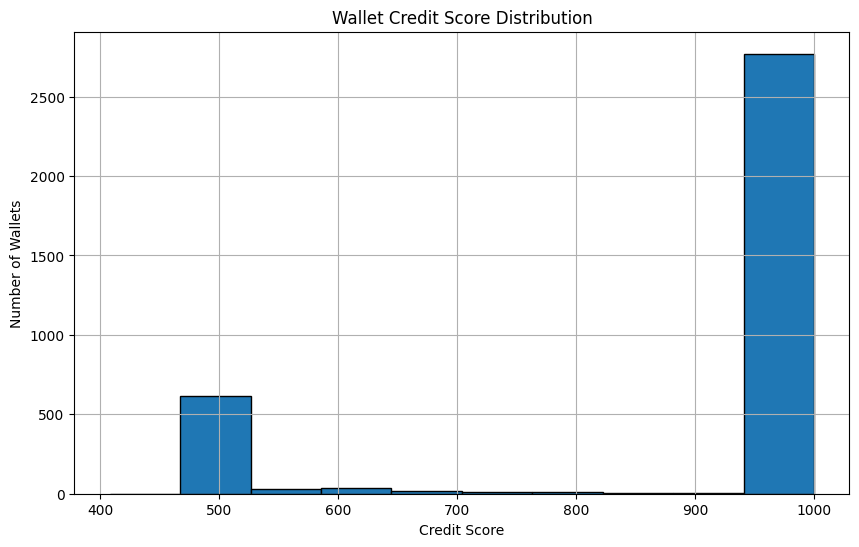

In [22]:
plt.figure(figsize=(10,6))
plt.hist(features_df["credit_score"], bins=10, edgecolor='black')
plt.title("Wallet Credit Score Distribution")
plt.xlabel("Credit Score")
plt.ylabel("Number of Wallets")
plt.grid(True)
plt.show()


In [23]:
bin_edges = np.arange(400, 1100, 100)
features_df['score_bin'] = pd.cut(features_df['credit_score'], bins=bin_edges, right=False)
bin_counts = features_df['score_bin'].value_counts().sort_index()
total_wallets = len(features_df)
print("| Score Range | Number of Wallets | % of Total |")
print("| ----------- | ---------------- | ---------- |")
for rng, count in bin_counts.items():
    print(f"| {rng} | {count} | {100*count/total_wallets:.2f}% |")


| Score Range | Number of Wallets | % of Total |
| ----------- | ---------------- | ---------- |
| [400, 500) | 2 | 0.06% |
| [500, 600) | 653 | 18.67% |
| [600, 700) | 36 | 1.03% |
| [700, 800) | 28 | 0.80% |
| [800, 900) | 7 | 0.20% |
| [900, 1000) | 15 | 0.43% |


## Interpretation Summary

In [24]:
top_wallets = features_df.sort_values("credit_score", ascending=False).head(5)
low_wallets = features_df.sort_values("credit_score").head(5)

print("Top 5 Wallets:")
display(top_wallets[["wallet", "credit_score", "repay_ratio", "num_liquidations"]])

print("Bottom 5 Wallets:")
display(low_wallets[["wallet", "credit_score", "repay_ratio", "num_liquidations"]])


Top 5 Wallets:


,wallet,credit_score,repay_ratio,num_liquidations
1748,0x02f21b7c148d5fc587a285d2f538f29c36176e52,1000,0.0,0
2266,0x03e03279f11cfca9f44bcfdb41d767af0e71a1a6,1000,0.0,0
2174,0x03aad34b8d729c000e980d676b5012ce024e6ba4,1000,0.0,0
2175,0x03ab5739cf27680d40bdfa8778a63a9239badc40,1000,0.0,0
2177,0x03abec9490d905b2e93c469e7f7409b085bfff8a,1000,0.0,0


Bottom 5 Wallets:


,wallet,credit_score,repay_ratio,num_liquidations
159,0x003be39433bde975b12411fbc3025d49d813a84f,408,0.0,3
1712,0x02e2b3f9e177e918e67e25b1a1b6a739049f9e22,483,0.0,0
974,0x0198d8a7463819a22facc2b96a7402f1bbbd1a82,500,0.0,0
2604,0x0486b904c347c7794e70a37c8d53a67b64b38b5f,500,0.0,0
2608,0x0488456ea17ec42ad21df20efb4a35a37d710064,500,0.0,0
